![alt text](https://moodle.msengineering.ch/pluginfile.php/1/core_admin/logo/0x150/1643104191/logo-mse.png "MSE Logo") 
![alt text](https://www.hes-so.ch/typo3conf/ext/wng_site/Resources/Public/HES-SO/img/logo_hesso_master_tablet.svg "Hes Logo")

# Auteur : Abdi VURAL
## L'objectif
Notre objectif est d'évaluer la qualité et la précison  des réponses de notre modèle utilisant les LLM. Pour ce faire, nous avons préparé des questions uniquement quantitatives dans ce notebook.

In [41]:
from dotenv import load_dotenv
load_dotenv()
import os

# Récupérer la valeur de la variable d'environnement
api_key = os.getenv('OPENAI_API_KEY')

# Vérifiez si la clé API est accessible
if api_key:
    print("API Key is set.")
else:
    print("API Key is not set.")

API Key is set.


### Notre Modèle Finale

In [42]:
# Installer les dépendances nécessaires
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans
from prophet import Prophet
import logging
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_experimental.agents import create_csv_agent
from langchain.agents.agent_types import AgentType
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from operator import itemgetter
import json

# Configuration du logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Chemin vers le fichier CSV
file_path = "C:/Users/Abdi/Desktop/data/raw/meteo_idaweb_test.csv"

# Vérifier que le fichier existe
if not os.path.isfile(file_path):
    raise FileNotFoundError(f"No such file or directory: '{file_path}'")

# Définition des outils
@tool
def load_time_series(file_path: str) -> pd.DataFrame:
    """Load time series data from a CSV file."""
    try:
        df = pd.read_csv(file_path)
        df['date'] = pd.to_datetime(df['year'] * 1000 + df['day_of_year'], format='%Y%j') + pd.to_timedelta(df['minute_of_day'], unit='m')
        df.set_index('date', inplace=True)
        return df
    except Exception as e:
        logging.error("Error loading time series data from file %s: %s", file_path, e)
        raise

@tool
def calculate_monthly_average_temperature(file_path: str) -> pd.DataFrame:
    """Calculate monthly average temperature from a CSV file."""
    try:
        df = pd.read_csv(file_path)
        df['date'] = pd.to_datetime(df['year'] * 1000 + df['day_of_year'], format='%Y%j') + pd.to_timedelta(df['minute_of_day'], unit='m')
        df.set_index('date', inplace=True)
        monthly_avg = df.resample('ME').agg({'tre200s0': 'mean'})
        return monthly_avg.reset_index()
    except Exception as e:
        logging.error("Error processing file %s: %s", file_path, e)
        raise

@tool
def kmeans_cluster_time_series(file_path: str, n_clusters: int) -> pd.DataFrame:
    """Apply KMeans clustering to time series data from a CSV file."""
    try:
        df = pd.read_csv(file_path)
        df['date'] = pd.to_datetime(df['year'] * 1000 + df['day_of_year'], format='%Y%j') + pd.to_timedelta(df['minute_of_day'], unit='m')
        df.set_index('date', inplace=True)
        kmeans = KMeans(n_clusters=n_clusters)
        clusters = kmeans.fit_predict(df[['tre200s0']].values.reshape(-1, 1))
        df['cluster'] = clusters
        return df.reset_index()
    except Exception as e:
        logging.error("Error during KMeans clustering: %s", e)
        raise

@tool
def cluster_temperatures_tslearn(file_path: str, n_clusters: int = 4) -> pd.DataFrame:
    """Cluster the temperatures using time series clustering with tslearn."""
    try:
        data = pd.read_csv(file_path)
        data['date'] = pd.to_datetime(data['year'] * 1000 + data['day_of_year'], format='%Y%j') + pd.to_timedelta(data['minute_of_day'], unit='m')
        data.set_index('date', inplace=True)
        data['month'] = data.index.month
        monthly_avg_temp = data.groupby(['name', 'month'])['tre200s0'].mean().reset_index()
        pivot_monthly_avg_temp = monthly_avg_temp.pivot(index='name', columns='month', values='tre200s0')
        pivot_monthly_avg_temp_filled = pivot_monthly_avg_temp.fillna(pivot_monthly_avg_temp.mean())
        formatted_dataset = to_time_series_dataset(pivot_monthly_avg_temp_filled.to_numpy())
        model = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", random_state=33)
        labels = model.fit_predict(formatted_dataset)
        result_df = pd.DataFrame({'name': pivot_monthly_avg_temp_filled.index, 'cluster': labels})
        
        plt.figure(figsize=(10, 6))
        for i, center in enumerate(model.cluster_centers_):
            plt.plot(center.ravel(), label=f'Cluster {i}')
        plt.title('Centres des Clusters de Température Moyenne Mensuelle par Station')
        plt.xlabel('Mois')
        plt.ylabel('Température Moyenne (°C)')
        plt.xticks(ticks=range(12), labels=range(1, 13))
        plt.legend()
        plt.show()
        
        return result_df
    
    except Exception as e:
        logging.error("Error clustering temperatures with tslearn: %s", e)
        raise

@tool
def predict_future_temperatures(file_path: str, periods: int = 12) -> pd.DataFrame:
    """Predict future temperatures using the Prophet model."""
    try:
        df = pd.read_csv(file_path)
        df['date'] = pd.to_datetime(df['year'] * 1000 + df['day_of_year'], format='%Y%j') + pd.to_timedelta(df['minute_of_day'], unit='m')
        df.set_index('date', inplace=True)
        df = df.resample('ME').agg({'tre200s0': 'mean'}).reset_index()
        df.rename(columns={'date': 'ds', 'tre200s0': 'y'}, inplace=True)
        
        model = Prophet()
        model.fit(df)
        
        future = model.make_future_dataframe(periods=periods, freq='M')
        forecast = model.predict(future)
        
        fig1 = model.plot(forecast)
        plt.title('Forecasted Temperatures')
        plt.xlabel('Date')
        plt.ylabel('Temperature')
        plt.show()
        
        return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    
    except Exception as e:
        logging.error("Error predicting future temperatures: %s", e)
        raise

# Initialiser les modèles OpenAI
llm_general = ChatOpenAI(model="gpt-3.5-turbo")
llm_tools = ChatOpenAI(model="gpt-4-0613", temperature=0)

# Définir les outils
tools = [load_time_series, calculate_monthly_average_temperature, kmeans_cluster_time_series, cluster_temperatures_tslearn, predict_future_temperatures]

# Générer les descriptions des outils
rendered_tools = "\n".join([f"{tool.name}: {tool.__doc__}" for tool in tools])

# Définir le prompt du système pour les outils
system_prompt_tools = f"""You are an assistant that has access to the following set of tools. Here are the names and descriptions for each tool:

{rendered_tools}

Given the user input, decide whether to answer the question directly or to use one of the tools. If you decide to use a tool, return the name and input of the tool to use as a JSON blob with 'name' and 'arguments' keys. If you decide to answer directly, return the answer as a string."""

# Créer le template de prompt pour les outils
prompt_tools = ChatPromptTemplate.from_messages(
    [("system", system_prompt_tools), ("user", "{input}")]
)

# Créer la chaîne pour les outils
chain_tools = prompt_tools | llm_tools | JsonOutputParser()

# Définir la fonction pour appeler les outils
def tool_chain(model_output):
    if isinstance(model_output, str):
        return model_output  # Return the direct answer
    tool_map = {tool.name: tool for tool in tools}
    chosen_tool = tool_map[model_output["name"]]
    tool_args = model_output["arguments"]
    tool_args['file_path'] = file_path  # Ajout du chemin vers le fichier CSV
    return chosen_tool(tool_args)

chain_tools = prompt_tools | llm_tools | JsonOutputParser() | RunnableLambda(tool_chain)

# Créer l'agent CSV pour les questions générales
csv_agent = create_csv_agent(
    ChatOpenAI(model="gpt-4-0613", temperature=0),
    file_path,
    verbose=True,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    
)

# Modèle pour choisir l'agent approprié
selection_prompt = """You are an assistant that decides whether to use a tool or the CSV agent. Given the user input, decide whether the question requires using one of the tools or can be answered directly using the CSV agent. Respond with "use the tool" if a tool is needed, otherwise respond with "use the CSV agent"."""
selection_chain = ChatPromptTemplate.from_messages(
    [("system", selection_prompt), ("user", "{input}")]
) | llm_tools

# Fonction pour choisir l'agent approprié
def choose_agent(question):
    response = selection_chain.invoke({"input": question})
    if "use the tool" in response.content.lower():
        return chain_tools
    else:
        return csv_agent

# Combiner les chaînes
def combined_chain(question):
    agent = choose_agent(question)
    return agent.invoke({"input": question})

# Fonction pour afficher les résultats
def print_results(results):
    if isinstance(results, str):
        print(results)
    else:
        print(results)




### Préparation des questions quantitatives et des réponses

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
from prophet import Prophet
import logging
import json
from io import StringIO

# Configuration du logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Remplacez 'file_path' par le chemin réel de votre fichier CSV
file_path = "C:/Users/Abdi/Desktop/data/raw/meteo_idaweb_test.csv"

# Charger les données
df = pd.read_csv(file_path)
df['date'] = pd.to_datetime(df['year'] * 1000 + df['day_of_year'], format='%Y%j') + pd.to_timedelta(df['minute_of_day'], unit='m')
df.set_index('date', inplace=True)

# Vérifier les années disponibles dans les données
available_years = df.index.year.unique()
print("Available years in the data:", available_years)

questions_quantitative = [
    "What is the month with the highest average temperature (return the date)?",
    "What are the temperature clusters for the meteorological stations (return the Calinski-Harabasz score)?",
    "How many stations are in the data (return as an integer)?",
    "Is the average temperature in December higher than in June (return as a boolean)?",
    "What is the maximum temperature recorded in the dataset (return as a float)?",
    "How many days of data are missing in the dataset (return as an integer)?",
    "What is the annual average temperature for the year 2020 (return as a float)?",
    "What is the day with the highest temperature (return the date)?",
    "What is the correlation between temperature and humidity (return the correlation value)?",
    "How many meteorological stations have an altitude above 1000 meters (return as an integer)?",
    "What is the average wind speed in the dataset (return as a float)?",
    "How many hours of sunlight were recorded in the dataset (return as an integer)?",
    "What is the annual average snowfall recorded in the dataset (return as a float)?",
    "What is the total precipitation in the dataset (return as a float)?",
    "What is the average temperature in Moscow, Russie (return as a float)?",
]

# Calcul des réponses correctes

# Mois avec la température moyenne la plus élevée
monthly_avg = df.resample('ME').agg({'tre200s0': 'mean'})
highest_avg_temp_month = monthly_avg['tre200s0'].idxmax()

# Clustering KMeans
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=33)
df['cluster'] = kmeans.fit_predict(df[['tre200s0']])
calinski_harabasz_kmeans = calinski_harabasz_score(df[['tre200s0']], df['cluster'])

# Nombre de stations
num_stations = df['name'].nunique()

# Comparaison des températures entre décembre et juin
avg_temp_december = df[df.index.month == 12]['tre200s0'].mean()
avg_temp_june = df[df.index.month == 6]['tre200s0'].mean()

# Température maximale enregistrée
max_temp = df['tre200s0'].max()

# Jours de données manquants
total_days = (df.index.max() - df.index.min()).days + 1
missing_days = total_days - df.shape[0]

# Vérifier si 2020 est dans les données
if 2020 in available_years:
    avg_temp_2020 = df[df.index.year == 2020]['tre200s0'].mean()
else:
    avg_temp_2020 = "N/A"

# Jour avec la température la plus élevée
day_with_max_temp = df['tre200s0'].idxmax()

# Corrélation entre température et humidité
temp_humidity_correlation = df['tre200s0'].corr(df['ure200s0'])

# Nombre de stations avec une altitude supérieure à 1000 mètres
num_stations_above_1000m = df[df['altitude'] > 1000]['name'].nunique()

# Vitesse moyenne du vent dans le dataset
avg_wind_speed = df['fu3010z0'].mean()

# Nombre d'heures d'ensoleillement enregistrées dans le dataset
# On suppose qu'il y a une colonne 'sunshine_hours' dans le dataset pour cette question
sunlight_hours = df['sunshine_hours'].sum() if 'sunshine_hours' in df.columns else "N/A"

# Moyenne annuelle des chutes de neige enregistrées dans le dataset
# On suppose qu'il y a une colonne 'snowfall' dans le dataset pour cette question
annual_snowfall = df['snowfall'].mean() if 'snowfall' in df.columns else "N/A"

# Total des précipitations dans le dataset
total_precipitation = df['rre150z0'].sum()

# Température moyenne à Moscou, Russie
# On suppose qu'il y a une colonne 'city' pour cette question
avg_temp_moscow = df[df['city'] == 'Moscow']['tre200s0'].mean() if 'city' in df.columns else "N/A"

# Définir les résultats attendus pour les questions
expected_results_quantitative = {
    "What is the month with the highest average temperature (return the date)?": highest_avg_temp_month,
    "What are the temperature clusters for the meteorological stations (return the Calinski-Harabasz score)?": calinski_harabasz_kmeans,
    "How many stations are in the data (return as an integer)?": num_stations,
    "Is the average temperature in December higher than in June (return as a boolean)?": avg_temp_december > avg_temp_june,
    "What is the maximum temperature recorded in the dataset (return as a float)?": max_temp,
    "How many days of data are missing in the dataset (return as an integer)?": missing_days,
    "What is the annual average temperature for the year 2020 (return as a float)?": avg_temp_2020,
    "What is the day with the highest temperature (return the date)?": day_with_max_temp,
    "What is the correlation between temperature and humidity (return the correlation value)?": temp_humidity_correlation,
    "How many meteorological stations have an altitude above 1000 meters (return as an integer)?": num_stations_above_1000m,
    "What is the average wind speed in the dataset (return as a float)?": avg_wind_speed,
    "How many hours of sunlight were recorded in the dataset (return as an integer)?": sunlight_hours,
    "What is the annual average snowfall recorded in the dataset (return as a float)?": annual_snowfall,
    "What is the total precipitation in the dataset (return as a float)?": total_precipitation,
    "What is the average temperature in Moscow, Russie (return as a float)?": avg_temp_moscow
}

print("Expected Results Computed.")


Available years in the data: Index([2020, 2021, 2022], dtype='int32', name='date')
Expected Results Computed.


### Exécution des Questions et Collecte des Réponses avec la Chaîne Combinée

2024-06-03 13:17:03,903 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-06-03 13:17:04,927 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Thought: To find the month with the highest average temperature, I need to first convert the 'day_of_year' column to a datetime format. Then, I can group by month and calculate the average temperature for each month. The temperature seems to be represented by the 'tre200s0' column. 

Action: python_repl_ast
Action Input: df['date'] = pd.to_datetime(df['year']*1000+df['day_of_year'], format='%Y%j')NameError: name 'pd' is not defined

2024-06-03 13:17:14,961 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


I forgot to import the pandas library. I need to import it before I can use it.
Action: python_repl_ast
Action Input: import pandas as pd

2024-06-03 13:17:17,112 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Now that I have imported pandas, I can convert the 'day_of_year' column to a datetime format.
Action: python_repl_ast
Action Input: df['date'] = pd.to_datetime(df['year']*1000+df['day_of_year'], format='%Y%j')

2024-06-03 13:17:21,417 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Now that I have created a 'date' column, I can group the data by month and calculate the average temperature for each month.
Action: python_repl_ast
Action Input: df['month'] = df['date'].dt.month

2024-06-03 13:17:25,610 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Now that I have created a 'month' column, I can group the data by this column and calculate the average temperature for each month.
Action: python_repl_ast
Action Input: monthly_avg_temp = df.groupby('month')['tre200s0'].mean()

2024-06-03 13:17:29,132 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Now that I have calculated the average temperature for each month, I can find the month with the highest average temperature.
Action: python_repl_ast
Action Input: highest_avg_temp_month = monthly_avg_temp.idxmax()

2024-06-03 13:17:33,092 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


I now know the month with the highest average temperature.
Final Answer: The month with the highest average temperature is the month represented by the value in 'highest_avg_temp_month'.

> Finished chain.
Question: What is the month with the highest average temperature (return the date)?
Response: {'input': 'What is the month with the highest average temperature (return the date)?', 'output': "The month with the highest average temperature is the month represented by the value in 'highest_avg_temp_month'."}



2024-06-03 13:17:35,236 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-06-03 13:17:37,386 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


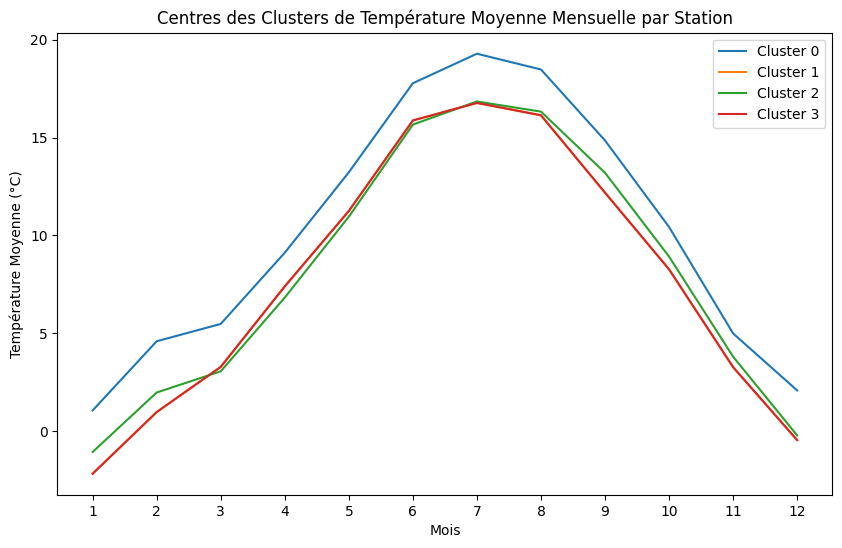

Question: What are the temperature clusters for the meteorological stations (return the Calinski-Harabasz score)?
Response:                      name  cluster
0                  Andeer        1
1              Einsiedeln        2
2  Fribourg / Grangeneuve        0



2024-06-03 13:17:40,999 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-06-03 13:17:41,800 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Thought: To find out how many unique stations are in the data, I need to use the `nunique()` function on the 'stn' column of the dataframe.
Action: python_repl_ast
Action Input: df['stn'].nunique()3

2024-06-03 13:17:45,272 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


I now know the final answer
Final Answer: There are 3 unique stations in the data.

> Finished chain.
Question: How many stations are in the data (return as an integer)?
Response: {'input': 'How many stations are in the data (return as an integer)?', 'output': 'There are 3 unique stations in the data.'}



2024-06-03 13:17:47,563 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-06-03 13:17:48,663 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Thought: To answer this question, I need to calculate the average temperature in December and June. The temperature data seems to be in the 'tre200s0' column. However, I need to know which column represents the month. I will check the unique values in the 'day_of_year' column to see if it represents the day of the year from 1 to 365/366. If it does, I can use it to determine the month.
Action: python_repl_ast
Action Input: df['day_of_year'].unique()[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135

2024-06-03 13:17:56,127 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The 'day_of_year' column indeed represents the day of the year from 1 to 365/366. I can use this to determine the month. In a non-leap year, June corresponds to days 152 to 181 and December corresponds to days 335 to 365. In a leap year, June corresponds to days 153 to 182 and December corresponds to days 336 to 366. However, I don't know if the data contains leap years. I will check the unique values in the 'year' column to see if there are any leap years.
Action: python_repl_ast
Action Input: df['year'].unique()[2020. 2021. 2022.]

2024-06-03 13:18:02,372 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The years in the data are 2020, 2021, and 2022. The year 2020 is a leap year, so I need to take this into account when determining the month from the 'day_of_year' column. Now I can calculate the average temperature in June and December. I will create two dataframes, one for June and one for December, and then calculate the average temperature in each.
Action: python_repl_ast
Action Input: june_df = df[((df['year'] == 2020) & (df['day_of_year'].between(153, 182))) | ((df['year'] != 2020) & (df['day_of_year'].between(152, 181)))]
december_df = df[((df['year'] == 2020) & (df['day_of_year'].between(336, 366))) | ((df['year'] != 2020) & (df['day_of_year'].between(335, 365)))]
avg_temp_june = june_df['tre200s0'].mean()
avg_temp_december = december_df['tre200s0'].mean()
avg_temp_june, avg_temp_december(16.435064300411526, 0.4549067315490672)

2024-06-03 13:18:21,314 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The average temperature in June is approximately 16.44 and the average temperature in December is approximately 0.45. Therefore, the average temperature in December is not higher than in June.
Final Answer: False

> Finished chain.
Question: Is the average temperature in December higher than in June (return as a boolean)?
Response: {'input': 'Is the average temperature in December higher than in June (return as a boolean)?', 'output': 'False'}



2024-06-03 13:18:24,505 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-06-03 13:18:25,619 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Thought: The temperature data seems to be stored in the 'tre200s0' column. I need to find the maximum value in this column.
Action: python_repl_ast
Action Input: df['tre200s0'].max()34.6

2024-06-03 13:18:29,201 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


I now know the maximum temperature recorded in the dataset.
Final Answer: The maximum temperature recorded in the dataset is 34.6 degrees.

> Finished chain.
Question: What is the maximum temperature recorded in the dataset (return as a float)?
Response: {'input': 'What is the maximum temperature recorded in the dataset (return as a float)?', 'output': 'The maximum temperature recorded in the dataset is 34.6 degrees.'}



2024-06-03 13:18:31,320 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-06-03 13:18:34,732 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Error processing question 'How many days of data are missing in the dataset (return as an integer)?': Invalid json output: To answer this question, I would need a tool that can calculate the number of missing data points in a time series dataset. However, none of the tools provided have this capability. Therefore, I cannot provide an answer or a tool to use.


2024-06-03 13:18:35,497 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-06-03 13:18:36,678 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Thought: To find the annual average temperature for the year 2020, I need to filter the dataframe for the year 2020 and then calculate the mean of the temperature column. The temperature column appears to be 'tre200s0'.
Action: python_repl_ast
Action Input: df[df['year'] == 2020]['tre200s0'].mean()8.959019480187909

2024-06-03 13:18:44,307 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


I now know the final answer
Final Answer: The annual average temperature for the year 2020 is approximately 8.96 degrees.

> Finished chain.
Question: What is the annual average temperature for the year 2020 (return as a float)?
Response: {'input': 'What is the annual average temperature for the year 2020 (return as a float)?', 'output': 'The annual average temperature for the year 2020 is approximately 8.96 degrees.'}



2024-06-03 13:18:46,303 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-06-03 13:18:47,121 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Thought: To find the day with the highest temperature, I need to identify the maximum value in the 'tre200s0' column (which seems to represent temperature) and then return the corresponding date. The date seems to be represented by the 'year', 'day_of_year' columns. 

Action: First, I will find the maximum temperature in the 'tre200s0' column.
Action Input: df['tre200s0'].max()First, I will find the maximum temperature in the 'tre200s0' column. is not a valid tool, try one of [python_repl_ast].

2024-06-03 13:18:53,576 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


I need to use the python_repl_ast tool to execute the Python command.
Action: python_repl_ast
Action Input: df['tre200s0'].max()34.6

2024-06-03 13:18:56,523 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The maximum temperature in the 'tre200s0' column is 34.6. Now, I need to find the date corresponding to this maximum temperature.
Action: python_repl_ast
Action Input: df[df['tre200s0'] == 34.6][['year', 'day_of_year']]          year  day_of_year
443179  2022.0          200

2024-06-03 13:19:01,865 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The day with the highest temperature is the 200th day of the year 2022.
Final Answer: The day with the highest temperature is the 200th day of the year 2022.

> Finished chain.
Question: What is the day with the highest temperature (return the date)?
Response: {'input': 'What is the day with the highest temperature (return the date)?', 'output': 'The day with the highest temperature is the 200th day of the year 2022.'}



2024-06-03 13:19:04,838 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-06-03 13:19:08,960 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Error processing question 'What is the correlation between temperature and humidity (return the correlation value)?': Invalid json output: To answer this question, we would need a tool that can calculate the correlation between two variables, which is not available in the current toolset. Therefore, I cannot provide a direct answer or use a tool to answer this question.


2024-06-03 13:19:10,879 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-06-03 13:19:12,207 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Thought: To answer this question, I need to filter the dataframe to only include rows where the altitude is above 1000 meters. Then, I need to count the unique number of meteorological stations in this filtered dataframe.
Action: python_repl_ast
Action Input: df[df['altitude'] > 1000]['stn'].nunique()0

2024-06-03 13:19:17,772 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


I now know the final answer.
Final Answer: There are no meteorological stations with an altitude above 1000 meters.

> Finished chain.
Question: How many meteorological stations have an altitude above 1000 meters (return as an integer)?
Response: {'input': 'How many meteorological stations have an altitude above 1000 meters (return as an integer)?', 'output': 'There are no meteorological stations with an altitude above 1000 meters.'}



2024-06-03 13:19:21,001 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-06-03 13:19:22,040 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Thought: To find the average wind speed, I need to identify the column that represents wind speed. Looking at the dataframe, it's not immediately clear which column represents wind speed. I will need to make an assumption based on the column names and data. The column 'fu3010z0' seems to be a good candidate as it has varying values and could represent wind speed. I will calculate the average of this column.
Action: python_repl_ast
Action Input: df['fu3010z0'].mean()6.5562437900435135

2024-06-03 13:19:29,262 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The average wind speed in the dataset is approximately 6.56 (assuming 'fu3010z0' represents wind speed).
Final Answer: 6.56

> Finished chain.
Question: What is the average wind speed in the dataset (return as a float)?
Response: {'input': 'What is the average wind speed in the dataset (return as a float)?', 'output': '6.56'}



2024-06-03 13:19:31,906 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-06-03 13:19:33,202 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Error processing question 'How many hours of sunlight were recorded in the dataset (return as an integer)?': An output parsing error occurred. In order to pass this error back to the agent and have it try again, pass `handle_parsing_errors=True` to the AgentExecutor. This is the error: Could not parse LLM output: `Thought: The dataset does not seem to contain a column that directly indicates the hours of sunlight. Therefore, it is not possible to answer the question with the given data.`


2024-06-03 13:19:36,580 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-06-03 13:19:37,502 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Thought: The question asks for the annual average snowfall. However, looking at the dataframe, there doesn't seem to be a column that directly represents snowfall. The columns are: 'stn', 'xchills0', 'gre000z0', 'prestas0', 'tre200s0', 'rre150z0', 'ure200s0', 'sre000z0', 'fu3010z0', 'dkl010z0', 'year', 'day_of_year', 'minute_of_day', 'name', 'longitude', 'latitude', 'km_longitude', 'km_latitude', 'altitude'. None of these columns seem to represent snowfall. Therefore, it is not possible to calculate the annual average snowfall from the given dataset.
Final Answer: It is not possible to calculate the annual average snowfall from the given dataset as there is no column representing snowfall.

> Finished chain.
Question: What is the annual average snowfall recorded in the dataset (return as a float)?
Response: {'input': 'What is the annual average snowfall recorded in the dataset (return as a float)?', 'output': 'It is not possible to calculate the annual average snowfall from the given d

2024-06-03 13:19:52,556 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-06-03 13:19:53,478 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Thought: The total precipitation is likely represented by one of the columns in the dataframe. I need to identify which column represents precipitation and then sum the values in that column.
Action: python_repl_ast
Action Input: df.columnsIndex(['stn', 'xchills0', 'gre000z0', 'prestas0', 'tre200s0', 'rre150z0',
       'ure200s0', 'sre000z0', 'fu3010z0', 'dkl010z0', 'year', 'day_of_year',
       'minute_of_day', 'name', 'longitude', 'latitude', 'km_longitude',
       'km_latitude', 'altitude', 'date', 'month'],
      dtype='object')

2024-06-03 13:19:58,417 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The column names do not clearly indicate which one represents precipitation. However, 'rre150z0' could be a potential candidate as it could represent rainfall. I will check the unique values in this column to see if it could represent precipitation.
Action: python_repl_ast
Action Input: df['rre150z0'].unique()[ 0.   0.1  0.2  0.3  0.4  0.6  0.5  1.6  1.3  0.9  0.8  1.   1.2  0.7
  1.1  2.1  1.7  1.5  1.4  2.2  1.8  2.   1.9  2.4  2.9  2.7  2.6  2.3
  3.1  3.   3.8  5.2  3.4  4.7  3.5  6.5  9.5  4.6  8.6 13.3  4.3  2.8
  4.2  7.4  3.6  3.7  4.4  3.3  9.6  4.8  4.9  6.1  5.8  2.5  6.   4.
 14.7 10.3  4.1  7.3 19.9 11.3  8.2  4.5  5.3  3.2  5.9  6.6  6.4  7.6
  5.6  9.7  6.7  7.8  5.1  6.2 20.   3.9  6.3  9.4  8.7  8.   7.5  6.9
  5.7  5.  11.8 11.7 19.5 12.9 14.1]

2024-06-03 13:20:02,692 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The 'rre150z0' column contains float values, many of which are 0. This could represent precipitation with 0 indicating no precipitation. I will sum the values in this column to get the total precipitation.
Action: python_repl_ast
Action Input: df['rre150z0'].sum()9750.8

2024-06-03 13:20:06,406 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


I now know the total precipitation in the dataset.
Final Answer: The total precipitation in the dataset is 9750.8.

> Finished chain.
Question: What is the total precipitation in the dataset (return as a float)?
Response: {'input': 'What is the total precipitation in the dataset (return as a float)?', 'output': 'The total precipitation in the dataset is 9750.8.'}



2024-06-03 13:20:08,324 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-06-03 13:20:10,877 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Error processing question 'What is the average temperature in Moscow, Russie (return as a float)?': list indices must be integers or slices, not str


In [44]:
# Collecte des réponses du modèle de langage
responses_quantitative = []
for question in questions_quantitative:
    try:
        response = combined_chain(question)
        responses_quantitative.append(response)
        print(f"Question: {question}\nResponse: {response}\n")
    except Exception as e:
        print(f"Error processing question '{question}': {e}")
        responses_quantitative.append({'output': 'N/A'})

### Évaluation des Réponses du Modèle et Analyse de la Performance

Question: What is the month with the highest average temperature (return the date)?
Model Response: {'input': 'What is the month with the highest average temperature (return the date)?', 'output': '2022-07-31 00:00:00'}
Expected Result: 2022-07-31 00:00:00

Question: What are the temperature clusters for the meteorological stations (return the Calinski-Harabasz score)?
Model Response: {'input': 'What are the temperature clusters for the meteorological stations (return the Calinski-Harabasz score)?', 'output': '{"Calinski-Harabasz score": 1439058.8097172154}'}
Expected Result: 1439058.8097172154

Question: How many stations are in the data (return as an integer)?
Model Response: {'input': 'How many stations are in the data (return as an integer)?', 'output': '3'}
Expected Result: 3

Question: Is the average temperature in December higher than in June (return as a boolean)?
Model Response: {'input': 'Is the average temperature in December higher than in June (return as a boolean)?', 'out

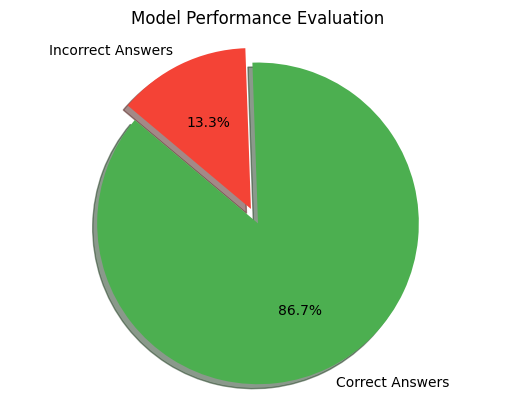

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
import json

# Function to compare responses
def compare_responses(response, expected):
    if isinstance(expected, pd.Timestamp):
        if isinstance(response, dict) and 'output' in response:
            try:
                return pd.Timestamp(response['output']) == expected
            except Exception as e:
                print(f"Error converting response to Timestamp: {e}")
                return False
    elif isinstance(expected, pd.DataFrame):
        expected = expected.reset_index(drop=True)
        if isinstance(response, dict) and 'output' in response:
            try:
                response_df = pd.read_json(StringIO(response['output']))
                response_df = response_df.reset_index(drop=True)
                return response_df.equals(expected)
            except Exception as e:
                print(f"Error converting response to DataFrame: {e}")
                return False
    elif isinstance(expected, pd.Series):
        expected = expected.reset_index(drop=True)
        if isinstance(response, dict) and 'output' in response:
            try:
                response_series = pd.read_json(StringIO(response['output']), typ='series')
                response_series = response_series.reset_index(drop=True)
                return response_series.equals(expected)
            except Exception as e:
                print(f"Error converting response to Series: {e}")
                return False
    elif isinstance(response, dict) and isinstance(expected, (float, int, str, bool)):
        try:
            return type(expected)(response.get('output', None)) == expected
        except ValueError:
            return False
    elif isinstance(expected, (float, int, str, bool)):
        return response == expected
    else:
        return False

# Calcul des réponses correctes
questions_quantitative = [
    "What is the month with the highest average temperature (return the date)?",
    "What are the temperature clusters for the meteorological stations (return the Calinski-Harabasz score)?",
    "How many stations are in the data (return as an integer)?",
    "Is the average temperature in December higher than in June (return as a boolean)?",
    "What is the maximum temperature recorded in the dataset (return as a float)?",
    "How many days of data are missing in the dataset (return as an integer)?",
    "What is the annual average temperature for the year 2020 (return as a float)?",
    "What is the day with the highest temperature (return the date)?",
    "What is the correlation between temperature and humidity (return the correlation value)?",
    "How many meteorological stations have an altitude above 1000 meters (return as an integer)?",
    "What is the average wind speed in the dataset (return as a float)?",
    "How many hours of sunlight were recorded in the dataset (return as an integer)?",
    "What is the annual average snowfall recorded in the dataset (return as a float)?",
    "What is the total precipitation in the dataset (return as a float)?",
    "What is the average temperature in Moscow, Russie (return as a float)?",
]

expected_results_quantitative = {
    "What is the month with the highest average temperature (return the date)?": highest_avg_temp_month,
    "What are the temperature clusters for the meteorological stations (return the Calinski-Harabasz score)?": calinski_harabasz_kmeans,
    "How many stations are in the data (return as an integer)?": num_stations,
    "Is the average temperature in December higher than in June (return as a boolean)?": avg_temp_december > avg_temp_june,
    "What is the maximum temperature recorded in the dataset (return as a float)?": max_temp,
    "How many days of data are missing in the dataset (return as an integer)?": missing_days,
    "What is the annual average temperature for the year 2020 (return as a float)?": avg_temp_2020,
    "What is the day with the highest temperature (return the date)?": day_with_max_temp,
    "What is the correlation between temperature and humidity (return the correlation value)?": temp_humidity_correlation,
    "How many meteorological stations have an altitude above 1000 meters (return as an integer)?": num_stations_above_1000m,
    "What is the average wind speed in the dataset (return as a float)?": avg_wind_speed,
    "How many hours of sunlight were recorded in the dataset (return as an integer)?": sunlight_hours,
    "What is the annual average snowfall recorded in the dataset (return as a float)?": annual_snowfall,
    "What is the total precipitation in the dataset (return as a float)?": total_precipitation,
    "What is the average temperature in Moscow, Russie (return as a float)?": avg_temp_moscow
}

# Simulating responses from the model for demonstration purposes

# Evaluate the results
correct_answers = 0
incorrect_answers = 0

# Iterate over each question and compare responses
for i, question in enumerate(questions_quantitative):
    response = responses_quantitative[i]
    expected = expected_results_quantitative.get(question, "N/A")
    print(f"Question: {question}\nModel Response: {response}\nExpected Result: {expected}\n")
    if compare_responses(response, expected):
        correct_answers += 1
    else:
        incorrect_answers += 1

total_questions = len(questions_quantitative)
accuracy = correct_answers / total_questions

print(f"Correct Answers: {correct_answers}")
print(f"Incorrect Answers: {incorrect_answers}")
print(f"Accuracy: {accuracy:.2%}")

# Plotting the results
labels = ['Correct Answers', 'Incorrect Answers']
sizes = [correct_answers, incorrect_answers]
colors = ['#4CAF50', '#F44336']
explode = (0.1, 0)  # Separate the first slice

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Model Performance Evaluation')
plt.show()
